In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
df_raw = pd.read_csv('../data/jeju_data_ver1/201901-202003.csv')

In [3]:
df_raw.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


# 서울, 경기, 제주 제외 지역 데이터만 추출

In [4]:
df = df_raw[~df_raw['CARD_SIDO_NM'].isin(['경기', '서울', '제주'])]

In [5]:
df.fillna('세종시', inplace=True)

In [6]:
df.columns

Index(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',
       'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'AMT', 'CNT'],
      dtype='object')

In [7]:
df.drop(['CARD_CCG_NM','HOM_SIDO_NM','HOM_CCG_NM'], axis=1, inplace=True)

In [8]:
df = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']).sum().reset_index()

In [9]:
df['CV'] = 0
df.loc[df['REG_YYMM']==202001, 'CV'] = 1
df.loc[df['REG_YYMM']==202002, 'CV'] = 2
df.loc[df['REG_YYMM']==202003, 'CV'] = 3

# Data Preprocessing

In [10]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [11]:
df['year'] = df['REG_YYMM'].apply(lambda x: grap_year(x))
df['month'] = df['REG_YYMM'].apply(lambda x: grap_month(x))
df = df.drop(['REG_YYMM'], axis=1)

In [12]:
def make_season(data):
    if data in [12, 1, 2]:
        return 'Winter'
    elif data in [3, 4, 5]:
        return 'Spring'
    elif data in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [13]:
df['Season'] = df['month'].apply(lambda x: make_season(x))

In [14]:
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month,Season
0,강원,건강보조식품 소매업,20s,1,1,4,311200,4,0,2019,1,Winter
1,강원,건강보조식품 소매업,30s,1,2,44,5169295,45,0,2019,1,Winter
2,강원,건강보조식품 소매업,30s,2,2,89,8618550,91,0,2019,1,Winter
3,강원,건강보조식품 소매업,40s,1,2,3,454420,3,0,2019,1,Winter
4,강원,건강보조식품 소매업,40s,1,3,53,6441165,60,0,2019,1,Winter


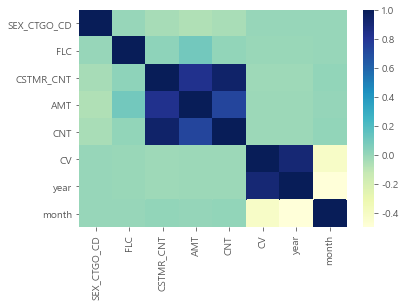

In [15]:
sns.heatmap(df.corr(),cmap='YlGnBu',fmt='.1g')

# Label Encoding

In [16]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156828 entries, 0 to 156827
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   CARD_SIDO_NM  156828 non-null  int32
 1   STD_CLSS_NM   156828 non-null  int32
 2   AGE           156828 non-null  int32
 3   SEX_CTGO_CD   156828 non-null  int64
 4   FLC           156828 non-null  int64
 5   CSTMR_CNT     156828 non-null  int64
 6   AMT           156828 non-null  int64
 7   CNT           156828 non-null  int64
 8   CV            156828 non-null  int64
 9   year          156828 non-null  int64
 10  month         156828 non-null  int64
 11  Season        156828 non-null  int32
dtypes: int32(4), int64(8)
memory usage: 12.0 MB


In [18]:
df.STD_CLSS_NM.unique()

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40,  4, 30])

In [19]:
df['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

# Preprocessing

In [46]:
# 변수명 지정
X_cols = list(df.columns)
X_cols.remove('AMT')

In [47]:
X = df.drop(['AMT','CSTMR_CNT', 'CNT'], axis=1)
y = np.log1p(df['AMT'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [48]:
# X = df.drop(['AMT'], axis=1)
# y = df[['month', 'AMT']]
# y['AMT'] = np.log1p(df['AMT'])
# X_train, X_test, y_train, y_test = X[X['month'].isin([1,2])], X[X['month']==3], y[y['month'].isin([1,2])]['AMT'], y[y['month']==3]['AMT']

# Light Gradient Boosting Machine

In [49]:
import lightgbm as lgb

In [50]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [51]:
params = {
            'learning_rate' : 0.1,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1        }

In [52]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.90094
[200]	valid_0's rmse: 0.744404
[300]	valid_0's rmse: 0.674611
[400]	valid_0's rmse: 0.636848
[500]	valid_0's rmse: 0.610819
[600]	valid_0's rmse: 0.583055
[700]	valid_0's rmse: 0.564358
[800]	valid_0's rmse: 0.54858
[900]	valid_0's rmse: 0.534049
[1000]	valid_0's rmse: 0.520026
[1100]	valid_0's rmse: 0.512838
[1200]	valid_0's rmse: 0.506253
[1300]	valid_0's rmse: 0.498719
[1400]	valid_0's rmse: 0.492929
[1500]	valid_0's rmse: 0.486072
[1600]	valid_0's rmse: 0.482169
[1700]	valid_0's rmse: 0.477231
[1800]	valid_0's rmse: 0.474231
[1900]	valid_0's rmse: 0.471741
[2000]	valid_0's rmse: 0.468366
[2100]	valid_0's rmse: 0.465336
[2200]	valid_0's rmse: 0.462548
[2300]	valid_0's rmse: 0.460405
[2400]	valid_0's rmse: 0.458824
[2500]	valid_0's rmse: 0.458004
[2600]	valid_0's rmse: 0.455864
[2700]	valid_0's rmse: 0.453573
[2800]	valid_0's rmse: 0.45239
[2900]	valid_0's rmse: 0.451037
[3000]	valid_0's rmse:

# Template

In [53]:
X.columns

Index(['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CV',
       'year', 'month', 'Season'],
      dtype='object')

In [54]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
AGEs          = df['AGE'].unique()
SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
FLCs          = df['FLC'].unique()
Seasons = df['Season'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for AGE in AGEs:
            for SEX_CTGO_CD in SEX_CTGO_CDs:
                for FLC in FLCs:
                    for year in years:
                        for month in months:
                            for Season in Seasons:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, AGE, SEX_CTGO_CD, FLC, year, month, Season])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'Season'])

In [56]:
temp

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,year,month,Season
0,0,0,1,1,1,2020,4,3
1,0,0,1,1,1,2020,4,1
2,0,0,1,1,1,2020,4,2
3,0,0,1,1,1,2020,4,0
4,0,0,1,1,1,2020,7,3
...,...,...,...,...,...,...,...,...
321435,13,30,0,2,5,2020,4,0
321436,13,30,0,2,5,2020,7,3
321437,13,30,0,2,5,2020,7,1
321438,13,30,0,2,5,2020,7,2


In [42]:
df2 = df[(df['year']==2020) & (df['month']==3)]
df3 = df[(df['year']==2020) & (df['month']==3)]
df4 = pd.concat([df2, df3], axis=0)

In [43]:
df4

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month,Season
147032,0,0,1,1,1,3,427510,2,3,2020,3,1
147033,0,0,2,1,2,38,5622890,37,3,2020,3,1
147034,0,0,2,2,2,30,2296125,38,3,2020,3,1
147035,0,0,3,1,2,3,257000,4,3,2020,3,1
147036,0,0,3,1,3,51,6490800,48,3,2020,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
156823,13,40,3,1,4,9,385700,10,3,2020,3,1
156824,13,40,4,1,4,19,2084350,31,3,2020,3,1
156825,13,40,4,2,4,4,99000,6,3,2020,3,1
156826,13,40,5,1,5,6,228800,6,3,2020,3,1


In [36]:
df4.drop(['AMT'], axis=1, inplace=True)

In [37]:
df4

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,CNT,CV,year,month,Season
147032,0,0,1,1,1,3,2,3,2020,3,1
147033,0,0,2,1,2,38,37,3,2020,3,1
147034,0,0,2,2,2,30,38,3,2020,3,1
147035,0,0,3,1,2,3,4,3,2020,3,1
147036,0,0,3,1,3,51,48,3,2020,3,1
...,...,...,...,...,...,...,...,...,...,...,...
156823,13,40,3,1,4,9,10,3,2020,3,1
156824,13,40,4,1,4,19,31,3,2020,3,1
156825,13,40,4,2,4,4,6,3,2020,3,1
156826,13,40,5,1,5,6,6,3,2020,3,1


In [44]:
temp = pd.merge(temp, df4, on=['CARD_SIDO_NM','STD_CLSS_NM','AGE','SEX_CTGO_CD','FLC', 'year', 'month', 'Season'])

In [58]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

In [59]:
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [60]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [61]:
v = pd.merge(temp[temp['REG_YYMM']==202004],df_raw[df_raw['REG_YYMM']==202003].groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['AMT']].sum().reset_index(), on=['STD_CLSS_NM','CARD_SIDO_NM'])
v = v.drop(['REG_YYMM', 'CARD_SIDO_NM'], axis=1)
v = v.rename(columns={'AMT_x' : '4월', 'AMT_y' : '3월'})
v['3월 대비 증감률'] = (v['4월'] - v['3월']) / v['3월'] * 100
v

,STD_CLSS_NM,4월,3월,3월 대비 증감률
0,건강보조식품 소매업,9.677735e+08,96059012,907.478069
1,골프장 운영업,1.853676e+10,2915797995,535.735502
2,과실 및 채소 소매업,8.273874e+09,994816943,731.698091
3,관광 민예품 및 선물용품 소매업,1.444829e+08,13317300,984.926119
4,그외 기타 스포츠시설 운영업,3.323372e+07,2075000,1501.624819
...,...,...,...,...
488,피자 햄버거 샌드위치 및 유사 음식점업,7.707144e+09,1315245299,485.985282
489,한식 음식점업,1.149645e+11,16152482704,611.745301
490,호텔업,6.969917e+07,15248550,357.087192
491,화장품 및 방향제 소매업,2.520107e+09,428881434,487.599859


In [78]:
v = pd.merge(temp[temp['REG_YYMM']==202004],df_raw[df_raw['REG_YYMM']==202003].groupby(['STD_CLSS_NM'])[['AMT']].sum().reset_index(), on=['STD_CLSS_NM'])
v = v.drop(['REG_YYMM', 'CARD_SIDO_NM'], axis=1)
v = v.rename(columns={'AMT_x' : '4월', 'AMT_y' : '3월'})
v['3월 대비 증감률'] = (v['4월'] - v['3월']) / v['3월'] * 100
v

,STD_CLSS_NM,4월,3월,3월 대비 증감률
0,호텔업,57418916.0,42998154,33.538096


In [62]:
temp.to_csv('./others_templates.csv',index=False, encoding='utf-8-sig')